## PyTomography GATE DIP (Deep Image Prior) Reconstruction

#### Import packages

In [1]:
import torch
import torch.nn as nn
from torch.optim import LBFGS
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta, PETTOFMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, DIPRecon
from pytomography.io.PET import gate
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import GaussianFilter
from pytomography.utils import sss
import matplotlib.pyplot as plt
import gc
import os
import numpy as np
from monai.transforms import ScaleIntensityd, CropForeground, Compose, DivisiblePadd, SpatialCropd, ThresholdIntensityd
from pytomography.io.PET import gate, shared
from pytomography.callbacks import DataStorageCallback
from skimage.metrics import structural_similarity as ssim 
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

#### Load GATE files

In [2]:
LOAD_FROM_ROOT = False # Set to true if .pt files not generated

#### PET Scanner information

In [3]:
# Path where the file is located
path = '/home/administrator/Secretária/ResultsY90'
# Uploading root files from the simulation
macro_path = os.path.join(path, 'GeometryPETVereos.mac')  
# Get information dictionary about the PET scanner - had to be changed because the order defined in PET VEREOS scanner was different from the defined by pytomography 'crystal', 'submodule', 'module', 'rsector', 'world' from pytomography
pet_info = gate.get_detector_info(
    path = macro_path,
    mean_interaction_depth=7.7,
    min_rsector_difference = 0
)

# We can look at the information of our PET scanner:
print(pet_info)

{'min_rsector_difference': 0, 'crystal_length': 19.0, 'radius': 389.7, 'crystalTransNr': 2, 'crystalTransSpacing': 4.0, 'crystalAxialNr': 2, 'crystalAxialSpacing': 4.0, 'submoduleTransNr': 4, 'submoduleTransSpacing': 8.0, 'submoduleAxialNr': 4, 'submoduleAxialSpacing': 8.0, 'moduleTransNr': 4, 'moduleTransSpacing': 32.85, 'moduleAxialNr': 5, 'moduleAxialSpacing': 32.85, 'rsectorTransNr': 18, 'rsectorAxialNr': 1, 'NrCrystalsPerRing': 576, 'NrRings': 40, 'firstCrystalAxis': 1}


#### Normalization correction

In [4]:
# Once it is ran, the normalization weights corresponding to each pair of detector IDs will be obtained (due to geometry/crystal orientation).
if LOAD_FROM_ROOT:
    normalization_paths = [os.path.join(path, '/home/administrator/Secretária/ResultsY90/PetVereoslistmode_normalization.root')]

    # Get normalization weights for all possible detector ID pairs
    # Function to get sensitivty factor from a cylindrical calibration phantom
    normalization_weights = gate.get_normalization_weights_cylinder_calibration(
        normalization_paths,
        pet_info,
        cylinder_radius = 349, # mm radius of the thin cylindrical shell used for calibration
        include_randoms=False
    )

    torch.save(normalization_weights, os.path.join(path, 'normalization_weights_noTOF.pt'))
normalization_weights = torch.load(os.path.join(path, 'normalization_weights_noTOF.pt'))

#### ROOT upload files

In [5]:
# Paths to ROOT files containing data
path_root = '/home/administrator/Secretária/ResultsY90/'
paths = [os.path.join(path_root, 'PetVereoslistmode_Y90.root')]

#### Total Coincidences

In [6]:
if LOAD_FROM_ROOT:
    detector_total_ids = gate.get_detector_ids_from_root(
        paths,
        pet_info)
    torch.save(detector_total_ids, os.path.join(path, 'detector_ids_totalnotof_events.pt'))
detector_total_ids = torch.load(os.path.join(path, 'detector_ids_totalnotof_events.pt'))
print(f"Found {len(detector_total_ids)} Total events")
print("Saved total events to files")

Found 8609228 Total events
Saved total events to files


#### Random coincidences

In [7]:
# Open listmode of all delayed events
if LOAD_FROM_ROOT:
    detector_ids_randoms = gate.get_detector_ids_from_root(
        paths,
        pet_info,
        substr = 'Delay')
    torch.save(detector_ids_randoms, os.path.join(path, 'detector_ids_delays_notof.pt'))
detector_ids_randoms= torch.load(os.path.join(path, 'detector_ids_delays_notof.pt'))
print(f"Found {len(detector_ids_randoms)} random events")
print("Saved total random to files")

Found 148152 random events
Saved total random to files


#### Random Estimation

In [8]:
# Convert these to a sinogram
# sinogram order is (r, θ, z)
sinogram_delays = gate.listmode_to_sinogram(detector_ids_randoms, pet_info)
print("Original sinogram shape:", sinogram_delays.shape)

Original sinogram shape: torch.Size([288, 577, 1600])


In [9]:
# Smooth the sinogram
# The 1st Gaussian is applied along θ
# The 2nd along r
# The 3rd and 4th along both z1 and z2
# Finally, it flattens back to (r, θ, z)
# Each kernel_size controls the number of pixels covered by the kernel.

sinogram_randoms_estimate = gate.smooth_randoms_sinogram(
    sinogram_delays, pet_info,
    sigma_r=3, # how far from the center a line of response (LOR) is
    sigma_theta=3, # the rotation angle around the scanner
    sigma_z=1.5, # which ring pair or axial slice you’re looking a
    kernel_size_r=15,
    kernel_size_theta=15,
    kernel_size_z=9
)
print(sinogram_randoms_estimate.shape)

torch.Size([288, 577, 1600])


In [10]:
# Convert back to listmode
lm_delays = shared.sinogram_to_listmode(detector_total_ids, sinogram_randoms_estimate , pet_info)
print(lm_delays.shape)
print(f"lm_delays range: [{lm_delays.min():.6f}, {lm_delays.max():.6f}]")

torch.Size([8609228])
lm_delays range: [0.000000, 0.018214]


#### Scatter Estimation

In [11]:
## estimates scatters via the single scatter simulation (SSS) algorithm (w or w/o time of flight). 
# In order to use SSS, we need an initial reconstruction of the data (without scatter estimation). 
# We use this reconstruction as a proxy to estimate scatter.

object_meta_2 = ObjectMeta(
    dr=(2.21,2.21,2.21), # voxel size
    shape=(125,122,93) # dimensions
)

# reconstruct the data without scatter estimation (but using randoms)

atten_map = gate.get_aligned_attenuation_map(os.path.join(path, 'attenuation_image-HU.hdr'), object_meta_2).to(pytomography.device) # attenuation map
normalization_weights = torch.load(os.path.join(path, 'normalization_weights_noTOF.pt')) # upload normalization file
proj_meta_2 = PETLMProjMeta(
    detector_total_ids,  # total events
    pet_info,
    weights_sensitivity=normalization_weights # normalization
    )
psf_transform = GaussianFilter(6) # 6 PSF + 3 sigma
system_matrix = PETLMSystemMatrix(
       object_meta_2,
       proj_meta_2,
       obj2obj_transforms = [psf_transform],
       N_splits=10,
       attenuation_map=atten_map
)

In [12]:
# We’ll reconstruct only using randoms as an estimate. 
# We need to pass the random sinogram estimate from before divided by the sensitivty sinogram as an additive term estimate to the likelihood function:

# Get additive term (without scatter term):
lm_sensitivity = system_matrix._compute_sensitivity_projection(all_ids=False)
additive_term = lm_delays / lm_sensitivity
additive_term[additive_term.isnan()] = 0 # remove NaN values

# Reconstruction
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
# reconstruct using only random estimation
recon_algorithm = OSEM(likelihood)

recon_without_scatter_estimation = recon_algorithm(3,15)

In [13]:
# This reconstruction is then used to estimate scatter in the SSS scatter estimation technique. 
sinogram_scatter = sss.get_sss_scatter_estimate(
    object_meta = object_meta_2,
    proj_meta = proj_meta_2, # required for the scaling of the scatter tails.
    pet_image = recon_without_scatter_estimation,  # the initial activity estimation which is used to estimate the scatter contribution.
    attenuation_image = atten_map, # used to compute compton cross sections
    system_matrix = system_matrix, # needed for the scaling of the scatter tails.
    proj_data = None, # assumes listmode
    image_stepsize = 4, # stepsize in x/y/z used for subsampling voxels in object space for the scatter simulation. DEFAULT VALUE
    attenuation_cutoff = 0.001,  # is used for two purposes: (i) any scatter point below this value is not considered and (ii) when the attenuation map is forward projected as a mask to scale the scatter tails, this is the cutoff value for the mask
    sinogram_interring_stepsize = 4, # the axial (between rings) stepsize between detector crystals used as sample points in the scatter simulation
    sinogram_intraring_stepsize = 4, # the transaxial stepsize between detector crystals used as sample points in the scatter simulation.
    sinogram_random = sinogram_randoms_estimate, # required for scaling the scatter tails at the end.
    N_splits = 4 # Increase only if memory issues
    )

[SSS] Starting scatter estimate...
[SSS] Listmode: True
[SSS] Computing sparse sinogram (non-TOF)...
[SSS] Attenuation map range: tensor(1.1211e-05, device='cuda:0') tensor(0.0235, device='cuda:0')
[SSS] Sparse sinogram shape: torch.Size([288, 577, 1600])
[SSS] Sparse sinogram: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0

In [14]:
# Now convert to listmode
lm_scatter = shared.sinogram_to_listmode(proj_meta_2.detector_ids, sinogram_scatter, proj_meta_2.info)
print(lm_scatter.shape)

torch.Size([8609228])


### Reconstruction with randoms, scatter, normalization and attenuation correction - 3i15s

In [15]:
# we can redefine our additive term to include scatter information and reconstruct:

additive_term = (lm_scatter + lm_delays) / lm_sensitivity # include randoms and scatters
additive_term[additive_term.isnan()] = 0
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term ## scatters and randoms corrections
    )
recon_algorithm = OSEM(likelihood)

recon_lm_nontof = recon_algorithm(3, 15)

#### 3D Gaussian Post-filter Reconstruction

In [16]:
## Post-reconstruction filter
filter = GaussianFilter(3) # FWHM of 3 mm
filter.configure(object_meta_2, proj_meta_2)
recon_lm_tof_filtered = filter(recon_lm_nontof)

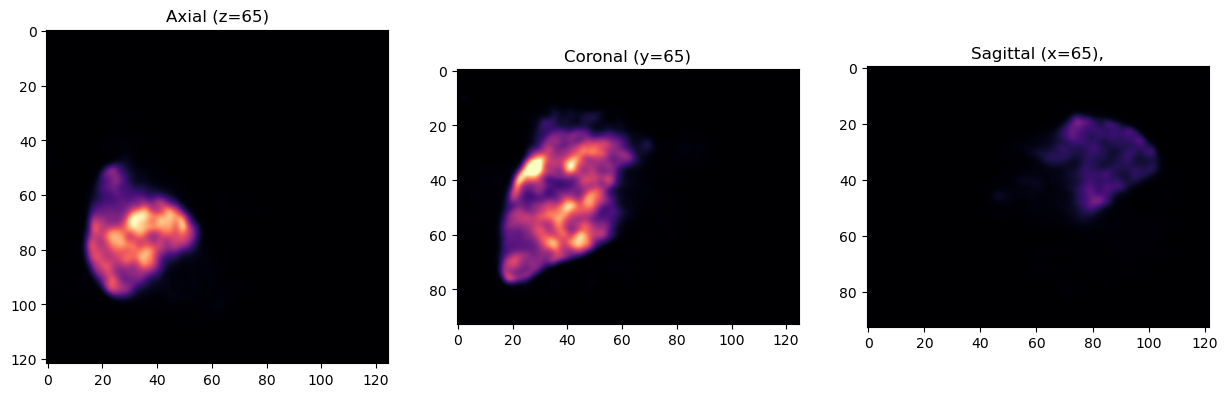

In [17]:
vmax = 15
cmap = 'magma'
slice_idx = 65  # choose the same slice index for all orientations

fig, ax = plt.subplots(1, 3, figsize=(15, 8), gridspec_kw={'wspace': 0.2})

# Axial (XY) plane
ax[0].imshow(recon_lm_tof_filtered[:, :, slice_idx].cpu().T, cmap=cmap,
             interpolation='gaussian', vmax=vmax, origin='upper')
ax[0].set_title(f'Axial (z={slice_idx})',fontsize=12)
ax[0].axis('on')

# Coronal (XZ) plane
ax[1].imshow(recon_lm_tof_filtered[:, slice_idx, :].cpu().T, cmap=cmap,
             interpolation='gaussian', vmax=vmax, origin='upper')
ax[1].set_title(f'Coronal (y={slice_idx})', fontsize=12)
ax[1].axis('on')

# Sagittal (YZ) plane
ax[2].imshow(recon_lm_tof_filtered[slice_idx, :, :].cpu().T, cmap=cmap,
             interpolation='gaussian', vmax=vmax, origin='upper')
ax[2].set_title(f'Sagittal (x={slice_idx}),', fontsize=12)
ax[2].axis('on')

fig.tight_layout()
plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Liberation Serif"],
        "mathtext.fontset": "dejavuserif",
    })

plt.subplots_adjust(wspace=0.5)
plt.show()

## Neural Network

### 3D-UNet Arquitecture

##### The 3D-UNet has 5 levels and reduces the object dimensions by a factor of 2 (but increases the number of channels) in each downward block.

In [18]:
# A basic two-conv layer used on the encoder side (the “contracting” path) 
# learns spatial features while keeping spatial size the same (because padding='same').
def get_downward_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
        )

# A spatial downsampling block using a strided convolution
# halves the spatial dimensions (D, H, W) because stride=2, while keeping the number of channels unchanged.
def get_downsample_block(out_channels):
    return nn.Sequential(
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=2, padding=(1,1,1)),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
        )

# two 3×3 convolutions similar to get_downward_block, used at the bottom (bottleneck) of the U-Net
def get_bottleneck_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
        )

# Upsampling followed by a 1×1 conv
# doubles spatial dimensions, then reduces (or adjusts) channels to out_channels. Using 1×1 conv acts like a channel mixer / projector.
def get_bilinear_upsample_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, padding='same'),
        )

# Two 3×3 convs on the decoder side (the “expanding” path). Both convolutions keep in_channels channels
# refines features after skip-connection merging.
def get_upward_block(in_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(in_channels),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(in_channels),
            nn.LeakyReLU(),
        )

# Final refinement and projection to single channel output
# reduces channels to 1 (e.g., for a single segmentation probability map or regression target). 
# Note: no final activation (e.g., sigmoid) is applied here — that’s typically left to the loss function (e.g., use BCEWithLogitsLoss) or applied externally.
def get_final_block(in_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(in_channels),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels, 1, kernel_size=3, padding='same'),
        )

class UNetCustom(nn.Module):
    def __init__(self, n_channels=[4, 8, 16, 32, 64]):
        super().__init__()
        self.downward_block1 = get_downward_block(1, n_channels[0])
        self.downward_block2 = get_downward_block(n_channels[0], n_channels[1])
        self.downward_block3 = get_downward_block(n_channels[1], n_channels[2])
        self.downward_block4 = get_downward_block(n_channels[2], n_channels[3])
        self.downsample_block1 = get_downsample_block(n_channels[0])
        self.downsample_block2 = get_downsample_block(n_channels[1])
        self.downsample_block3 = get_downsample_block(n_channels[2])
        self.downsample_block4 = get_downsample_block(n_channels[3])
        self.bottleneck_block = get_bottleneck_block(n_channels[3], n_channels[4])
        self.upsample_block1 = get_bilinear_upsample_block(n_channels[4], n_channels[3])
        self.upsample_block2 = get_bilinear_upsample_block(n_channels[3], n_channels[2])
        self.upsample_block3 = get_bilinear_upsample_block(n_channels[2], n_channels[1])
        self.upsample_block4 = get_bilinear_upsample_block(n_channels[1], n_channels[0])
        self.upward_block1 = get_upward_block(n_channels[3])
        self.upward_block2 = get_upward_block(n_channels[2])
        self.upward_block3 = get_upward_block(n_channels[1])
        self.final_block = get_final_block(n_channels[0])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.downward_block1(x)
        x = self.downsample_block1(x1)
        x2 = self.downward_block2(x)
        x = self.downsample_block2(x2)
        x3 = self.downward_block3(x)
        x = self.downsample_block3(x3)
        x4 = self.downward_block4(x)
        x = self.downsample_block4(x4)
        x = self.bottleneck_block(x)
        x = self.upsample_block1(x) + x4
        x = self.upward_block1(x)
        x = self.upsample_block2(x) + x3
        x = self.upward_block2(x)
        x = self.upsample_block3(x) + x2
        x = self.upward_block3(x)
        x = self.upsample_block4(x) + x1
        x = self.final_block(x)
        return x

In [19]:
# This network actually expects a 5D image of shape [batch_size, n_channels, Lx, Ly, Lz], so we need to take this into account.
test_input = torch.ones((1,1,128,128,128))
test_output = UNetCustom()(test_input)
print(test_input.shape)
print(test_output.shape)

torch.Size([1, 1, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


In [20]:
from torchinfo import summary

model = UNetCustom()
summary(model, input_size=(1, 1, 128, 128, 128), depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
UNetCustom                               [1, 1, 128, 128, 128]     --
├─Sequential: 1-1                        [1, 4, 128, 128, 128]     --
│    └─Conv3d: 2-1                       [1, 4, 128, 128, 128]     112
│    └─BatchNorm3d: 2-2                  [1, 4, 128, 128, 128]     8
│    └─LeakyReLU: 2-3                    [1, 4, 128, 128, 128]     --
│    └─Conv3d: 2-4                       [1, 4, 128, 128, 128]     436
│    └─BatchNorm3d: 2-5                  [1, 4, 128, 128, 128]     8
│    └─LeakyReLU: 2-6                    [1, 4, 128, 128, 128]     --
├─Sequential: 1-2                        [1, 4, 64, 64, 64]        --
│    └─Conv3d: 2-7                       [1, 4, 64, 64, 64]        436
│    └─BatchNorm3d: 2-8                  [1, 4, 64, 64, 64]        8
│    └─LeakyReLU: 2-9                    [1, 4, 64, 64, 64]        --
├─Sequential: 1-3                        [1, 8, 64, 64, 64]        --
│    └─Conv3d: 

In [21]:
# to save neural network diagram
from torchviz import make_dot
import torch

model = UNetCustom()
x = torch.randn(1, 1, 128, 128, 128)

y = model(x)

# Create and save the diagram
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = "png"
dot.render("unet_custom_graph")


'unet_custom_graph.png'

### Fit and Prediction method

This reconstruction technique requires a prior_network that implements two functions: (i) a fit method that takes in an object (x) which the network f(z, theta) is subsequently fit to, and (ii) a predict function that returns the current network prediction f(z, theta)

In [22]:
# The next thing the DIP Prior needs is a class that implements a fit and predict method. 
# The fit method should take in an object (the PET image in this case) and update the neural networks weights. The predict method should yield the current prediction of the neural network. 

class DIPPrior():
    def __init__(
        self,
        network, # UNet
        anatomical_image, # CT image that is going to be used
        pipeline, # pipeline for preprocessing CT image this means align the CT with the PET 
        scale_factor=1, # constant to scale CT image by # a multiplier applied to the PET ground truth during training (often used to match intensity ranges)
        n_epochs=10, # how many epochs the network trains for when fitting
        lr = 0.1, # learning rate when fitting, hyperameter
    ):
        self.network = network
        self.anatomical_image = anatomical_image
        self.pipeline = pipeline
        self.n_epochs = n_epochs
        self.scale_factor = scale_factor
        self.lr = lr
        self.max_iter = 20
        self.loss_history = []  # Track loss for visualization

    def fit(self, object):
        # This method trains the network for n_epochs at a learning rate of lr
        # object is the PET image you pass in (e.g., an initial OSEM reconstruction) with shape like [Lx, Ly, Lz]. unsqueeze(0) makes it [1, Lx, Ly, Lz] so MONAI sees a channel dimension. 
        # After pipeline, data['NM'] and data['CT'] are preprocessed tensors (usually normalized, cropped, padded, etc).
        data = self.pipeline({'NM': object.unsqueeze(0), 'CT': self.anatomical_image.unsqueeze(0)})
        # Create LBFGS optimizer
        optimizer_lfbgs = LBFGS(self.network.parameters(), lr=self.lr, max_iter=self.max_iter, history_size=100)
        # Prepare ground truth and input
        NM_truth = data['NM'].unsqueeze(0) * self.scale_factor
        network_input = data['CT'].unsqueeze(0)
        criterion = torch.nn.MSELoss()
        
        # Clear previous loss history
        self.loss_history = []
        
        # Define loss function and closure
        def closure(optimizer):
            optimizer.zero_grad()
            NM_prediction = self.network(network_input)
            loss = criterion(NM_prediction, NM_truth)
            loss.backward()
            return loss
        
        print(f"Starting DIP prior training for {self.n_epochs} epochs...")
        print("-" * 50)
        
        # Run training with progress reporting
        for epoch in range(self.n_epochs):
            # Store loss before training step to compare
            with torch.no_grad():
                NM_prediction_before = self.network(network_input)
                loss_before = criterion(NM_prediction_before, NM_truth).item()
            
            # Train for one epoch (LBFGS does multiple inner iterations)
            loss_value = optimizer_lfbgs.step(lambda: closure(optimizer_lfbgs))
            
            # Store loss for visualization
            current_loss = loss_value.item()
            self.loss_history.append(current_loss)
            
            # Calculate improvement
            improvement = loss_before - current_loss
            
            # Print progress every epoch
            print(f"Epoch {epoch + 1:2d}/{self.n_epochs} - "
                  f"Loss: {current_loss:.6f} - ")
            
            # Print more detailed progress every 5 epochs or at the end
            if (epoch + 1) % 5 == 0 or epoch == self.n_epochs - 1:
                print(f" Current learning rate: {self.lr}")
                if improvement < 0:
                    print(" Loss increased - consider reducing learning rate")
        
        print("-" * 50)
        print("DIP prior training completed!")
        print(f"Final loss: {self.loss_history[-1]:.6f}")
        
        # Clear gradients and produce the learned prior
        self.network.zero_grad(set_to_none=True)
        with torch.no_grad():
            # Add batch/channel dimension
            network_prediction = self.network(data['CT'].unsqueeze(0)).squeeze()
        self.prior_object = self.pipeline.inverse({'NM': network_prediction.unsqueeze(0)})['NM'].as_tensor().squeeze() / self.scale_factor

    def predict(self):
        return self.prior_object.detach()
    
    def plot_loss_curve(self, save_path=None, show=True):
        """Plot the training loss curve"""
        if not self.loss_history:
            print("No loss history available. Run fit() first.")
            return
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.loss_history) + 1), self.loss_history, 'b-', linewidth=2, color='darkred')
        plt.title('DIP Prior Training Loss Curve', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss (MSE)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.yscale('log')  # Log scale often better for loss visualization
        
        # Add some statistics
        final_loss = self.loss_history[-1]
        best_loss = min(self.loss_history)
        improvement = ((self.loss_history[0] - final_loss) / self.loss_history[0]) * 100
        
        # Create custom legend with statistics
        legend_text = f'Training Loss\n\nFinal: {final_loss:.4f}\nBest: {best_loss:.4f}\nImprovement: {improvement:.1f}%'
    
        plt.legend([legend_text], loc='upper right', fontsize=12, 
               handlelength=0, handletextpad=0, frameon=True)
    
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Loss curve saved to: {save_path}")
        
        if show:
            plt.show()
    
    def get_loss_history(self):
        """Return the loss history as a numpy array"""
        return np.array(self.loss_history)
    
    def print_loss_statistics(self):
        """Print detailed loss statistics"""
        if not self.loss_history:
            print("No loss history available. Run fit() first.")
            return
        
        losses = np.array(self.loss_history)
        print("\n" + "="*50)
        print("LOSS STATISTICS")
        print("="*50)
        print(f"Initial loss: {losses[0]:.6f}")
        print(f"Final loss: {losses[-1]:.6f}")
        print(f"Best loss: {losses.min():.6f} (epoch {losses.argmin() + 1})")
        print(f"Total improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")
        print(f"Average loss: {losses.mean():.6f} ± {losses.std():.6f}")
        print("="*50)

    def evaluate_metrics(self, prediction=None, ground_truth=None):
        """Compute reconstruction quality metrics"""
        if prediction is None:
            prediction = self.prior_object
        prediction = prediction.detach().cpu().numpy()
        gt = ground_truth.detach().cpu().numpy()

        mse = np.mean((gt - prediction) ** 2)
        rmse = np.sqrt(mse)
        psnr = peak_signal_noise_ratio(gt, prediction, data_range=gt.max() - gt.min())
        ssim = structural_similarity(gt, prediction, data_range=gt.max() - gt.min())

        print("\n" + "="*50)
        print("RECONSTRUCTION METRICS")
        print("="*50)
        print(f"MSE  : {mse:.6f}")
        print(f"RMSE : {rmse:.6f}")
        print(f"PSNR : {psnr:.2f} dB")
        print(f"SSIM : {ssim:.4f}")
        print("="*50)

        return {'MSE': mse, 'RMSE': rmse, 'PSNR': psnr, 'SSIM': ssim}

### Data Preprocessing

#### Align CT image with PET Reconstruction space

In [23]:
# Spatial alignment between a high-resolution CT image and the PET reconstruction space.

import nibabel as nib
import numpy.linalg as npl
from scipy.ndimage import affine_transform

def align_ct_image(path, img=None):
    # Load CT NIfTI file
    data = nib.load(path)
    # Get image data as numpy array
    if img is None:
        img = data.get_fdata()
    Sx, Sy, Sz = -(np.array(img.shape)-1) / 2 # Center coordinates
    dx, dy, dz = data.header['pixdim'][1:4] # Voxel dimensions from header
    
    print(f"CT  image dimensions: Sx={Sx:4f}, Sy={Sy:4f}, Sz={Sz:4f}")
    print(f"CT voxel dimensions: dx={dx:.6f} mm, dy={dy:.6f} mm, dz={dz:.6f} mm")
    
    # Builds a 4×4 affine matrix M_highres that transforms from voxel coordinates to world coordinates for the MRI.

    M_ct = np.zeros((4,4))
    M_ct[0] = np.array([dx, 0, 0, Sx*dx])
    M_ct[1] = np.array([0, dy, 0, Sy*dy])
    M_ct[2] = np.array([0, 0, dz, Sz*dz])
    M_ct[3] = np.array([0, 0, 0, 1])

    # PET (target space)
    dx, dy, dz = object_meta_2.dr # PET voxel dimensions
    Sx, Sy, Sz = -(np.array(object_meta_2.shape)-1) / 2 # PET center coordinates

    print(f"PET voxel dimensions: dx={dx:.6f} mm, dy={dy:.6f} mm, dz={dz:.6f} mm")
    print(f"PET  image dimensions: Sx={Sx:4f}, Sy={Sy:4f}, Sz={Sz:4f}")

    # Builds a similar affine matrix M_pet for the PET reconstruction space.

    M_pet = np.zeros((4,4))  
    M_pet[0] = np.array([dx, 0, 0, Sx*dx])
    M_pet[1] = np.array([0, dy, 0, Sy*dy])
    M_pet[2] = np.array([0, 0, dz, Sz*dz])
    M_pet[3] = np.array([0, 0, 0, 1])

    # Computes the transformation - This calculates the transformation needed to go from CT world coordinates → PET world coordinates.
    # npl.inv(M_highres): Converts from CT world coordinates back to CT voxel coordinates 
    # @ M_pet: Then converts from CT voxel coordinates to PET world coordinates

    M = npl.inv(M_ct) @ M_pet

    # Applies the transformation
    return affine_transform(img, M, output_shape=object_meta_2.shape, mode='constant', order=1)
    # This resamples the CT image to match the PET space:
    # M: The computed transformation matrix
    # output_shape=object_meta.shape: Makes output same dimensions as PET (125,122,93)
    # mode='constant': Fills background with zeros
    # order=1: Uses linear interpolation (smooth resampling)

# Converts to PyTorch tensor
# Load here the CT image in NIFTI

ct_aligned = torch.tensor(align_ct_image('/home/administrator/Champalimaud dados/Imagens/ct_pet_y90.nii')).to(pytomography.device).to(torch.float32)

CT  image dimensions: Sx=-62.000000, Sy=-60.500000, Sz=-46.000000
CT voxel dimensions: dx=2.210000 mm, dy=2.210000 mm, dz=2.210000 mm
PET voxel dimensions: dx=2.210000 mm, dy=2.210000 mm, dz=2.210000 mm
PET  image dimensions: Sx=-62.000000, Sy=-60.500000, Sz=-46.000000


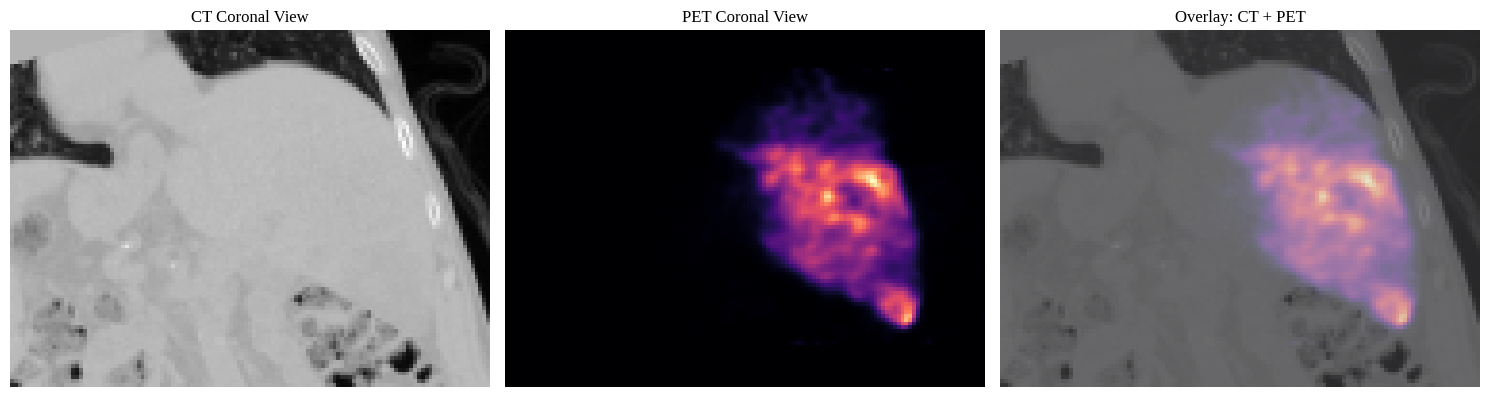

In [24]:
# Get the CT and PET data as numpy arrays
ct_data = ct_aligned.cpu().numpy()
pet_data = recon_lm_nontof.cpu().numpy()

# Apply the reflections you mentioned:
# PET image reflected on x-axis, CT image reflected on y-axis
ct_data_reflected = np.flip(ct_data, axis=1)  # Reflect CT on y-axis (axis=1)
pet_data_reflected = np.flip(pet_data, axis=(0, 2))  # Reflect PET on x-axis (axis=0) and z

# Find the middle slice for coronal view
coronal_slice = ct_data_reflected.shape[1] // 2

# Create the visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# CT coronal view (reflected on y-axis)
ax1.imshow(ct_data_reflected[:, coronal_slice, :].T, cmap='gray', origin='lower')
ax1.set_title('CT Coronal View', fontsize='12')
ax1.axis('off')

# PET coronal view (reflected on x-axis)
ax2.imshow(pet_data_reflected[:, coronal_slice, :].T, cmap='magma', origin='lower')
ax2.set_title('PET Coronal View', fontsize='12')
ax2.axis('off')

# Overlay (CT as grayscale + PET as color)
ax3.imshow(ct_data_reflected[:, coronal_slice, :].T, cmap='gray', origin='lower', alpha=0.7)
ax3.imshow(pet_data_reflected[:, coronal_slice, :].T, cmap='magma', origin='lower', alpha=0.5)
ax3.set_title('Overlay: CT + PET', fontsize='12')
ax3.axis('off')

plt.tight_layout()
plt.show()

### Prepare the dataset (CT and PET) for the neural network

In [25]:
# This pipeline prepares aligned CT and PET images for neural network processing by:
# Cropping to relevant regions
# Ensuring proper dimensions
# Normalizing intensity values

# ct_crop_above/below: Intensity thresholds for CT (typical HU values)

ct_crop_above = 250     # exclude negative values 
ct_crop_below = 120     # maximum inside liver sgementation

# compute_bounding_box(): Finds the smallest 3D box that contains all non-zero voxels 
# unsqueeze(0): Adds batch dimension [1, depth, height, width] for MONAI compatibility

roi_start, roi_end = CropForeground().compute_bounding_box(ct_aligned.unsqueeze(0))

# Data resampling for the Neural Network

pipeline = Compose([
    DivisiblePadd(['CT', 'NM'], 16, allow_missing_keys=True),
    # Pads images to make dimensions divisible by 16
    # Why: Many neural networks (especially UNets) work best with dimensions that are powers of 2 ; Example: If cropped to [110,100,80], pads to [112,112,80] (nearest multiples of 16)
    ThresholdIntensityd(['CT'], ct_crop_above, above=False, cval=ct_crop_above),
    # Clips CT intensities above 250 HU to 250
    # Why: Limits very bright values (bone, metal implants) that could dominate training ; Effect: [0, 1000] → [0, 250] (values >250 become 250)
    ThresholdIntensityd(['CT'], ct_crop_below, above=True, cval=ct_crop_below),
    # Clips CT intensities below 120 HU to 120
    # Why: Removes very dark values (air, background noise); Effect: [0, 250] → [120, 250] (values <120 become 120)
    ScaleIntensityd(['CT'], 0, 1)
    # Scales CT intensities from [120, 250] to [0, 1] 
    # Why: Normalizes data for neural network (networks prefer inputs in [0,1] or [-1,1]) ; Formula: (value - 120) / (250 - 120)
])

# Notice the PET image (NM) only goes through:
# Spatial cropping (removes background)
# Padding (makes dimensions divisible by 16)

### DIP Training

In [26]:
start_channels = 12
net = UNetCustom([start_channels,2*start_channels,4*start_channels,8*start_channels,16*start_channels]).to(pytomography.device)

In [27]:
# This makes the PET and CT operate in a similar [0–1] scale, making the loss much smaller (typically <1 after a few epochs).
dip_prior = DIPPrior(
    net,
    ct_aligned,
    pipeline,
    n_epochs=100,        # fewer epochs (DIP works best early)
    scale_factor=1,    # try scaling PET up to match CT intensity range
    lr=0.1            # smaller step size for stability
)

#### Pre-training DIP - Prior Network

In [ ]:
dip_prior.fit(recon_lm_nontof)

Starting DIP prior training for 100 epochs...
--------------------------------------------------
Epoch  1/100 - Loss: 2.281160 - 
Epoch  2/100 - Loss: 1.149673 - 
Epoch  3/100 - Loss: 0.413195 - 
Epoch  4/100 - Loss: 0.216879 - 
Epoch  5/100 - Loss: 0.160296 - 
 Current learning rate: 0.1
Epoch  6/100 - Loss: 0.134445 - 
Epoch  7/100 - Loss: 0.118700 - 
Epoch  8/100 - Loss: 0.105294 - 
Epoch  9/100 - Loss: 0.097602 - 
Epoch 10/100 - Loss: 0.091262 - 
 Current learning rate: 0.1
Epoch 11/100 - Loss: 0.085154 - 
Epoch 12/100 - Loss: 0.080515 - 
Epoch 13/100 - Loss: 0.076161 - 
Epoch 14/100 - Loss: 0.072032 - 
Epoch 15/100 - Loss: 0.069003 - 
 Current learning rate: 0.1
Epoch 16/100 - Loss: 0.065924 - 
Epoch 17/100 - Loss: 0.062913 - 
Epoch 18/100 - Loss: 0.059936 - 
Epoch 19/100 - Loss: 0.057719 - 
Epoch 20/100 - Loss: 0.055745 - 
 Current learning rate: 0.1
Epoch 21/100 - Loss: 0.054060 - 
Epoch 22/100 - Loss: 0.052488 - 
Epoch 23/100 - Loss: 0.050856 - 
Epoch 24/100 - Loss: 0.049340 - 

Loss curve saved to: /home/administrator/Secretária/ResultsY90/DIPResults/dip_prior_loss_curve.png


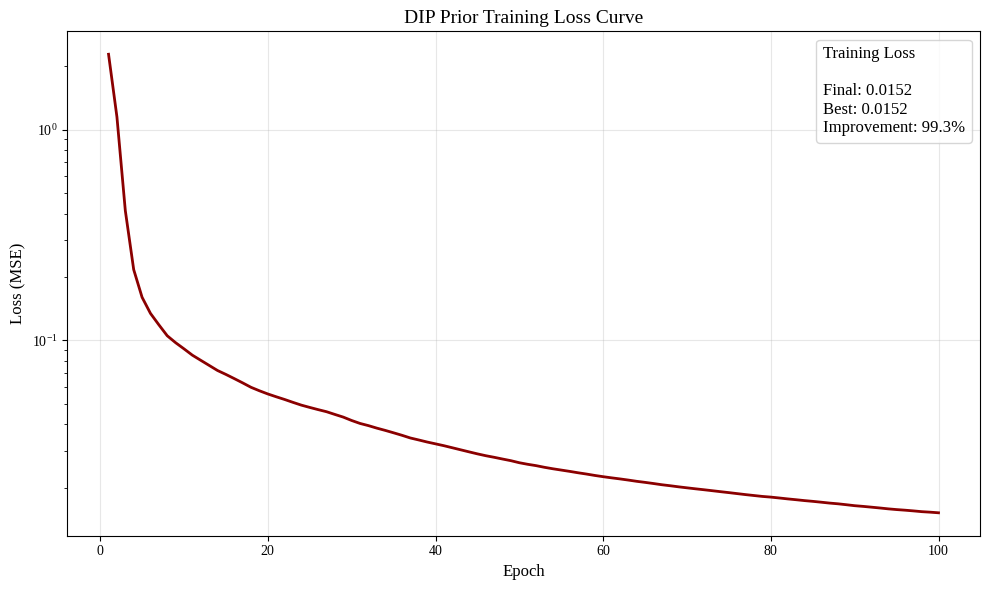

In [29]:
# Visualize the loss curve
save_directory = "/home/administrator/Secretária/ResultsY90/DIPResults"
dip_prior.plot_loss_curve(save_path=os.path.join(save_directory, 'dip_prior_loss_curve.png'))

In [30]:
# Print detailed statistics
dip_prior.print_loss_statistics()

# Get the prediction
prior_prediction = dip_prior.predict()


LOSS STATISTICS
Initial loss: 2.281160
Final loss: 0.015217
Best loss: 0.015217 (epoch 100)
Total improvement: 99.3%
Average loss: 0.075507 ± 0.252416


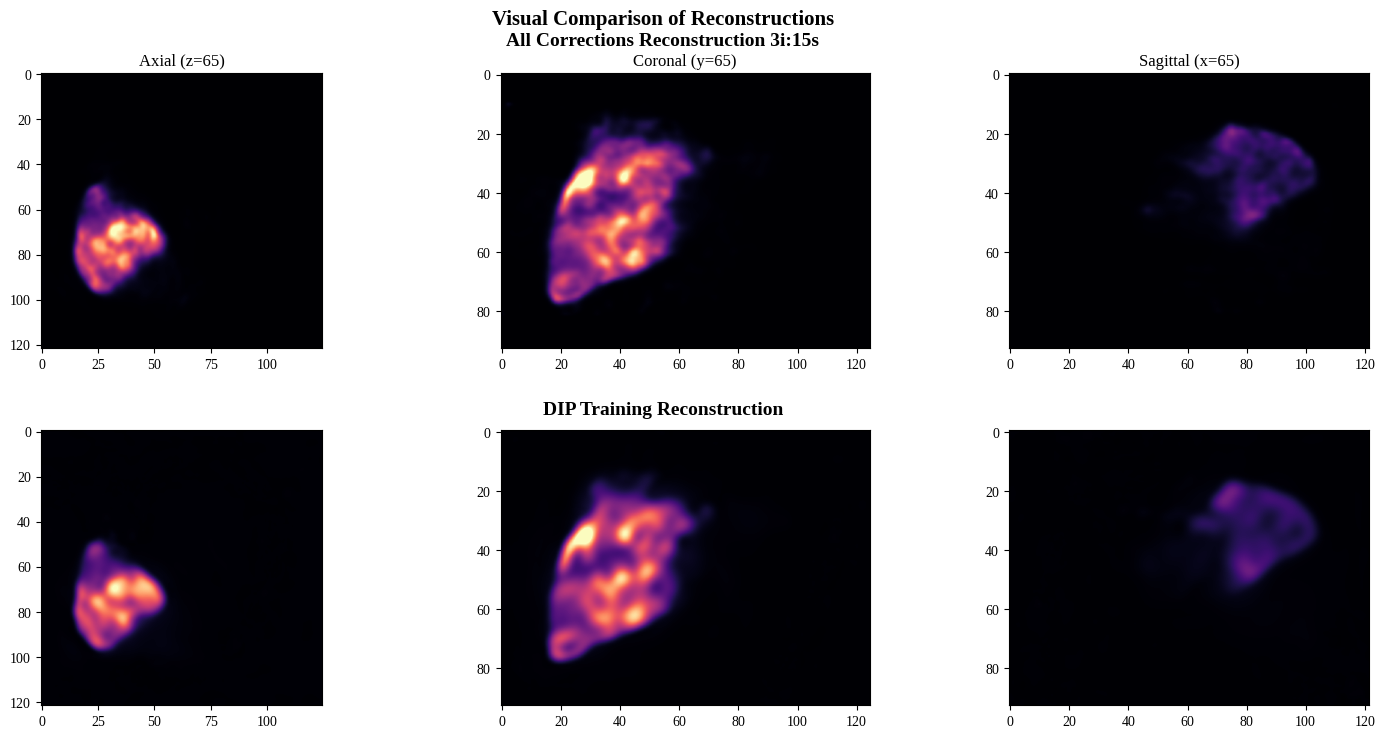

In [31]:
vmax = 15
cmap = 'magma'
slice_idx = 65  # same slice index for all orientations

fig, ax = plt.subplots(2, 3, figsize=(18, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

# --------------------------------------------------------
# TOP ROW — All corrections reconstruction
# --------------------------------------------------------
ax[0, 0].imshow(recon_lm_nontof[:, :, slice_idx].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[0, 0].set_title(f'Axial (z={slice_idx})', fontsize=12)
ax[0, 0].axis('on')

ax[0, 1].imshow(recon_lm_nontof[:, slice_idx, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[0, 1].set_title(f'Coronal (y={slice_idx})', fontsize=12)
ax[0, 1].axis('on')

ax[0, 2].imshow(recon_lm_nontof[slice_idx, :, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[0, 2].set_title(f'Sagittal (x={slice_idx})', fontsize=12)
ax[0, 2].axis('on')

# --------------------------------------------------------
# BOTTOM ROW — DIP reconstruction training
# --------------------------------------------------------
ax[1, 0].imshow(dip_prior.prior_object[:, :, slice_idx].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[1, 0].axis('on')

ax[1, 1].imshow(dip_prior.prior_object[:, slice_idx, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[1, 1].axis('on')

ax[1, 2].imshow(dip_prior.prior_object[slice_idx, :, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[1, 2].axis('on')

# --------------------------------------------------------
# Labels
# --------------------------------------------------------
fig.text(0.5, 0.94, "All Corrections Reconstruction 3i:15s", ha='center', va='center',
         fontsize=14, weight='bold')
fig.text(0.5, 0.48, "DIP Training Reconstruction", ha='center', va='center',
         fontsize=14, weight='bold')

fig.suptitle("Visual Comparison of Reconstructions", fontsize=15, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9, wspace=0.4, hspace=0.1)
plt.show()

#### Compute Training metrics

In [32]:
# --- Load ground truth ---
gt_tensor = torch.tensor(
    nib.load("/home/administrator/Secretária/ResultsY90/Results_all_corrections_3i15s/reconstruction_iteration_3.nii").get_fdata(),
    dtype=torch.float32
)

# --- Normalize both GT and DIP output to [0, 1] ---
# Avoid dividing by zero by adding a small epsilon
eps = 1e-8

# Normalize ground truth
gt_norm = (gt_tensor - gt_tensor.min()) / (gt_tensor.max() - gt_tensor.min() + eps)

# Normalize DIP output
prior_norm = (dip_prior.prior_object - dip_prior.prior_object.min()) / (dip_prior.prior_object.max() - dip_prior.prior_object.min() + eps)

# --- Evaluate metrics with normalized tensors ---
metrics = dip_prior.evaluate_metrics(prior_norm, gt_norm)



RECONSTRUCTION METRICS
MSE  : 0.008069
RMSE : 0.089826
PSNR : 20.93 dB
SSIM : 0.4170


### DIP Reconstruction Algorithm

In [50]:
dip_prior.n_epochs = 20    # N_SUBITERS2_DIP - How many epochs you train the network each time you fit the prior. Fewer epochs → faster, less risk of over-fitting; more epochs → stronger prior imprint but possibly bias.
dip_prior.max_iter = 20    # LBFGS_MAX_ITER - For LBFGS optimizer: maximum inner iterations. 
dip_prior.lr = 0.1        # learning rate LR_RECON - Learning rate for the prior network training. If loss is unstable, reduce this.

In [51]:
# Reconstruction with DIP algorithm - Implementation of Algorithm 1 from paper

# rho scales the weighting between regular EM updates and the DIP Prior (high rho means more weight to the prior)

recon_algorithm = DIPRecon(
    likelihood = likelihood, # Initialized likelihood function for the imaging system considered
    prior_network=dip_prior, # User defined prior network that implements the neural network  that predicts an object given a prior image. This network also implements a fit method that takes in an object and fits the network to the object
    rho=1e5,                 # Value of ρ used in the optimization procedure. Larger values of give larger weight to the neural network, while smaller values of give larger weight to the EM updates. Defaults to 1.
)

In [52]:
# Initiate Reconstruction

recon_DIP = recon_algorithm(n_iters=10, subit1=3, n_subsets_osem=15) 

# (n_iters, subit1, n_subsets_osem=1, callback=None)
# Number of iterations - Number of alternations of OSEM + prior retraining. More iterations → more convergence but longer run. Starting with 3 is acceptable.
# number of OSEM (or likelihood) subsets/iterations before retrain the DIP prior network (the “inner” subsets) - How many OSEM updates you run before retraining the prior network. Smaller → more frequent prior updates; larger → fewer updates but more OSEM steps between retrains.
# n_subsets_osem (int, optional) – Number of subsets to use in OSEM reconstruction. Defaults to 1. - Number of subsets in each OSEM update. Choose based on system matrix and simulation setup; more subsets → faster per iteration but may increase noise or instability.

Starting DIP prior training for 20 epochs...
--------------------------------------------------
Epoch  1/20 - Loss: 0.000027 - 
Epoch  2/20 - Loss: 0.000028 - 
Epoch  3/20 - Loss: 0.000028 - 
Epoch  4/20 - Loss: 0.000028 - 
Epoch  5/20 - Loss: 0.000028 - 
 Current learning rate: 0.1
Epoch  6/20 - Loss: 0.000028 - 
Epoch  7/20 - Loss: 0.000037 - 
Epoch  8/20 - Loss: 0.000028 - 
Epoch  9/20 - Loss: 0.000028 - 
Epoch 10/20 - Loss: 0.000028 - 
 Current learning rate: 0.1
Epoch 11/20 - Loss: 0.000028 - 
Epoch 12/20 - Loss: 0.000028 - 
Epoch 13/20 - Loss: 0.000027 - 
Epoch 14/20 - Loss: 0.000027 - 
Epoch 15/20 - Loss: 0.000027 - 
 Current learning rate: 0.1
Epoch 16/20 - Loss: 0.000027 - 
Epoch 17/20 - Loss: 0.000028 - 
Epoch 18/20 - Loss: 0.000028 - 
Epoch 19/20 - Loss: 0.000028 - 
Epoch 20/20 - Loss: 0.000028 - 
 Current learning rate: 0.1
--------------------------------------------------
DIP prior training completed!
Final loss: 0.000028
Starting DIP prior training for 20 epochs...
-----

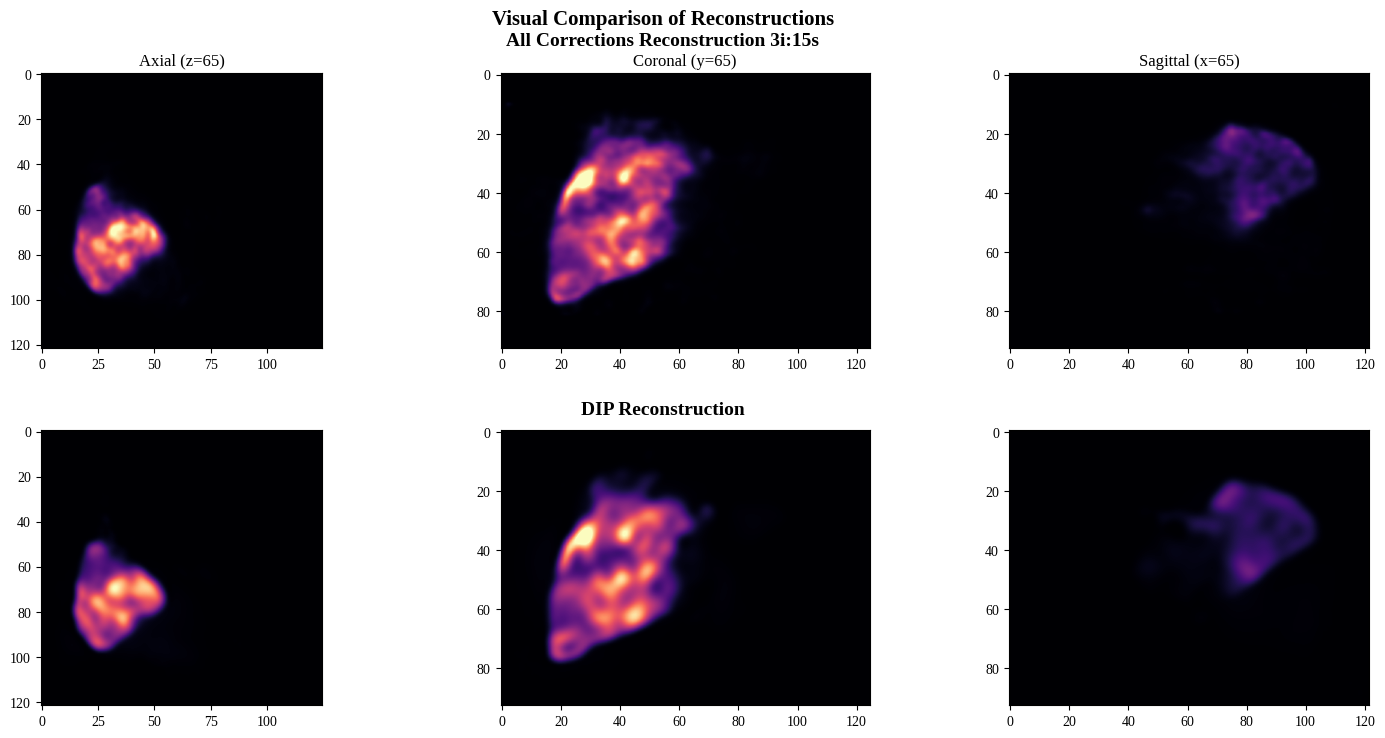

In [53]:
vmax = 15
cmap = 'magma'
slice_idx = 65  # same slice index for all orientations

fig, ax = plt.subplots(2, 3, figsize=(18, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

# --------------------------------------------------------
# TOP ROW — All corrections reconstruction
# --------------------------------------------------------
ax[0, 0].imshow(recon_lm_nontof[:, :, slice_idx].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[0, 0].set_title(f'Axial (z={slice_idx})', fontsize=12)
ax[0, 0].axis('on')

ax[0, 1].imshow(recon_lm_nontof[:, slice_idx, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[0, 1].set_title(f'Coronal (y={slice_idx})', fontsize=12)
ax[0, 1].axis('on')

ax[0, 2].imshow(recon_lm_nontof[slice_idx, :, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[0, 2].set_title(f'Sagittal (x={slice_idx})', fontsize=12)
ax[0, 2].axis('on')

# --------------------------------------------------------
# BOTTOM ROW — DIP reconstruction training
# --------------------------------------------------------
ax[1, 0].imshow(recon_DIP[:, :, slice_idx].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[1, 0].axis('on')

ax[1, 1].imshow(recon_DIP[:, slice_idx, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[1, 1].axis('on')

ax[1, 2].imshow(recon_DIP[slice_idx, :, :].cpu().T, cmap=cmap,
                interpolation='gaussian', vmax=vmax, origin='upper')
ax[1, 2].axis('on')

# --------------------------------------------------------
# Labels
# --------------------------------------------------------
fig.text(0.5, 0.94, "All Corrections Reconstruction 3i:15s", ha='center', va='center',
         fontsize=14, weight='bold')
fig.text(0.5, 0.48, "DIP Reconstruction", ha='center', va='center',
         fontsize=14, weight='bold')

fig.suptitle("Visual Comparison of Reconstructions", fontsize=15, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9, wspace=0.4, hspace=0.1)
plt.show()

#### Save DIP Reconstruction results
##### Conversion from tensor to NIfTI format

In [54]:
# --- VOXEL METADATA ---
voxel_size = object_meta_2.dr  # (dx, dy, dz)
print(f"Voxel size: {voxel_size}")

# --- SAVE ONLY FINAL RECONSTRUCTION ---
final_tensor = recon_DIP
recon_np = final_tensor.detach().cpu().numpy()
print("Reconstruction shape:", recon_np.shape)

# --- FIX ORIENTATION ---
if recon_np.ndim == 3:
    recon_np = np.flip(recon_np, axis=(0, 1, 2))
elif recon_np.ndim == 2:
    recon_np = np.flip(recon_np, axis=(0, 1))
else:
    print(f"⚠️ Unexpected tensor shape: {recon_np.shape} — skipping flipping.")

# --- CREATE AFFINE ---
affine = np.diag([voxel_size[0], voxel_size[1], voxel_size[2], 1])

# --- CREATE NIFTI ---
nifti_img = nib.Nifti1Image(recon_np, affine)

# Match voxel size to dimensionality
if recon_np.ndim == 3:
    nifti_img.header.set_zooms(voxel_size)
elif recon_np.ndim == 2:
    nifti_img.header.set_zooms(voxel_size[:2])

nifti_img.header['descrip'] = "Final OSEM reconstruction (flipped)"

# --- SAVE ---
file_path = os.path.join(save_directory, "final_reconstruction.nii")
nib.save(nifti_img, file_path)
print(f"✅ Saved final reconstruction to: {file_path}")

# --- VERIFY FILE ---
size_mb = os.path.getsize(file_path) / (1024 * 1024)
print(f"File size: {size_mb:.2f} MB")


Voxel size: (2.21, 2.21, 2.21)
Reconstruction shape: (125, 122, 93)
✅ Saved final reconstruction to: /home/administrator/Secretária/ResultsY90/DIPResults/final_reconstruction.nii
File size: 5.41 MB


#### Training of the best parameters for the DIP Reconstruction

In [ ]:
import itertools
import torch
import numpy as np

# Define ranges for parameters you want to test
rhos    = [1e5, 5e5, 1e6]     # prior weight scaling
subit1s = [10, 15, 20]        # number of subsets before retraining prior
lrs     = [0.1, 0.5, 1.0]     # learning rates for prior network training

# Keep other settings fixed
n_iters        = 3
n_subsets_osem = 15       
dip_epochs     = 10
dip_max_iter   = 20

results = []

for rho, subit1, lr in itertools.product(rhos, subit1s, lrs):
    # Set up the prior network parameters
    dip_prior.n_epochs  = dip_epochs
    dip_prior.max_iter  = dip_max_iter
    dip_prior.lr        = lr
    
    # Set up reconstruction algorithm
    recon_algorithm = DIPRecon(
        likelihood     = likelihood,
        prior_network  = dip_prior,
        rho            = rho,
    )
    # Run reconstruction
    recon = recon_algorithm(
        n_iters        = n_iters,
        subit1         = subit1,
        n_subsets_osem = n_subsets_osem
    )
    
    # Optionally compute a metric (e.g., final loss, or some ROI error)  
    # Here we assume you track loss_history in dip_prior
    final_loss = dip_prior.loss_history[-1] if hasattr(dip_prior, 'loss_history') else np.nan
    
    print(f"Test configuration → rho={rho}, subit1={subit1}, lr={lr} : final_loss={final_loss:.6f}")
    results.append({
        'rho': rho,
        'subit1': subit1,
        'lr': lr,
        'final_loss': final_loss
    })

# After running all tests, find the best configuration
best = min(results, key=lambda x: x['final_loss'])
print("\n=> Best configuration found:")
print(best)


Starting DIP prior training for 10 epochs...
--------------------------------------------------
Epoch  1/10 - Loss: 0.000050 - 
Epoch  2/10 - Loss: 0.000055 - 
Epoch  3/10 - Loss: 0.000052 - 
Epoch  4/10 - Loss: 0.000052 - 
Epoch  5/10 - Loss: 0.000051 - 
   Current learning rate: 0.1
Epoch  6/10 - Loss: 0.000051 - 
Epoch  7/10 - Loss: 0.000051 - 
Epoch  8/10 - Loss: 0.000051 - 
Epoch  9/10 - Loss: 0.000051 - 
Epoch 10/10 - Loss: 0.000051 - 
   Current learning rate: 0.1
--------------------------------------------------
DIP prior training completed!
Final loss: 0.000051
Starting DIP prior training for 10 epochs...
--------------------------------------------------
Epoch  1/10 - Loss: 0.000125 - 
Epoch  2/10 - Loss: 0.000126 - 
Epoch  3/10 - Loss: 0.000126 - 
Epoch  4/10 - Loss: 0.000126 - 
Epoch  5/10 - Loss: 0.000126 - 
   Current learning rate: 0.1
Epoch  6/10 - Loss: 0.000125 - 
Epoch  7/10 - Loss: 0.000125 - 
Epoch  8/10 - Loss: 0.000125 - 
Epoch  9/10 - Loss: 0.000125 - 
Epoch 10